In [1]:
import pandas as pd
import keras
from keras.layers import LSTM, SimpleRNN, Input, Bidirectional, TimeDistributed, Dropout, Dense, Activation, BatchNormalization
from keras.models import Model
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


## Model

In [2]:
def get_model(input_shape, output_shape, lr = 0.00001, path = None):
    inputs = Input(shape=input_shape)
    X = Dropout(0.5)(inputs)
    X = Dense(4096, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(2048, activation='relu')(X)
    X = Dense(2048, activation='relu')(X)
    X = Bidirectional(LSTM(1024, return_sequences=True))(X)
    outputs = TimeDistributed(Dense(output_shape, activation='softmax'))(X)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.train.AdamOptimizer(lr),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],
    )
    
    if path != None:
        model.load_weights(path)
    
    return model

## Callbacks

In [3]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
        self.ax1 = ax1
        self.ax2 = ax2
    
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        self.ax1.plot(self.x, self.losses, label="loss")
        self.ax1.plot(self.x, self.val_losses, label="val loss")
        self.ax1.legend()
        self.ax2.plot(self.x, self.acc, label="accuracy")
        self.ax2.plot(self.x, self.val_acc, label="val accuracy")
        self.ax2.legend()
        plt.show()
        
        for i in range(self.i):
            print('Epoch ' + str(i+1))
            print('-----------------------')
            print('- Loss:', self.losses[i])
            print('- Accuracy:', self.acc[i])
            print('- Validation loss:', self.val_losses[i])
            print('- Validation accuracy:', self.val_acc[i])
            print(' ')
            
checkpoint = keras.callbacks.ModelCheckpoint(
    './convnet_weights/lstm/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
    monitor='val_loss',
    verbose=0, 
    save_best_only=False, 
    save_weights_only=True, 
    mode='max', 
    period=1,
)

## Data

In [4]:
def generator(path, mode, num_batches):
    counter = 0
    indices = np.random.permutation(list(range(num_batches)))
    
    while True:
        if counter >= num_batches:
            counter = 0
            indices = np.random.permutation(list(range(num_batches)))

        features = np.load(path + 'features_' + mode + '_' + str(indices[counter]) + '.npy')
        classes = np.load(path + 'classes_' + mode + '_' + str(indices[counter]) + '.npy')
        
        counter += 1
        yield features, classes
        
def get_metadata(path):
    features = np.load(path + 'features_train_0.npy')
    input_shape = features.shape[1:]
    classes = np.load(path + 'classes_train_0.npy')
    num_classes = classes.shape[2]
    steps_per_epoch = len(fnmatch.filter(os.listdir(path),'*features_train_*'))
    validation_steps = len(fnmatch.filter(os.listdir(path),'*features_dev_*'))
    return input_shape, num_classes, steps_per_epoch, validation_steps

## Training

In [5]:
input_shape, num_classes, steps_per_epoch, validation_steps = get_metadata('./features/lstm/2_steps/')

In [6]:
print('Input shape:', input_shape)
print('Number of classes:', num_classes)
print('Steps per epoch:', steps_per_epoch) 
print('Validation steps:', validation_steps)

Input shape: (2, 6144)
Number of classes: 167
Steps per epoch: 101
Validation steps: 26


In [7]:
model = get_model(
    input_shape, 
    num_classes, 
    lr=0.00001,
    path='./convnet_weights/lstm/weights.25-1.87.hdf5',
)
plot_losses = PlotLosses()

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 6144)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 6144)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2, 4096)           25169920  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 4096)           16384     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 4096)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2, 2048)           8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 2, 2048)           4196352   
__________

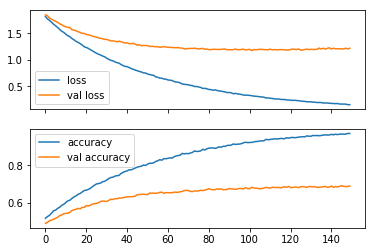

Epoch 1
-----------------------
- Loss: 1.81404980656
- Accuracy: 0.519849285196
- Validation loss: 1.84580382587
- Validation accuracy: 0.493208573047
 
Epoch 2
-----------------------
- Loss: 1.77037947692
- Accuracy: 0.528628029721
- Validation loss: 1.8304060033
- Validation accuracy: 0.498188952161
 
Epoch 3
-----------------------
- Loss: 1.74193338817
- Accuracy: 0.535270354146
- Validation loss: 1.78728568435
- Validation accuracy: 0.506942348379
 
Epoch 4
-----------------------
- Loss: 1.70716433832
- Accuracy: 0.546768179067
- Validation loss: 1.76415988458
- Validation accuracy: 0.510262601925
 
Epoch 5
-----------------------
- Loss: 1.66902489867
- Accuracy: 0.559275947831
- Validation loss: 1.74427053988
- Validation accuracy: 0.515092062583
 
Epoch 6
-----------------------
- Loss: 1.63992300791
- Accuracy: 0.562849596171
- Validation loss: 1.72279088061
- Validation accuracy: 0.519317838871
 
Epoch 7
-----------------------
- Loss: 1.60702967822
- Accuracy: 0.572094468

- Validation loss: 1.21751768036
- Validation accuracy: 0.686839723296
 
Epoch 149
-----------------------
- Loss: 0.153416992757
- Accuracy: 0.967565258035
- Validation loss: 1.20357131242
- Validation accuracy: 0.688348928626
 
Epoch 150
-----------------------
- Loss: 0.154444006769
- Accuracy: 0.967487570067
- Validation loss: 1.21684493729
- Validation accuracy: 0.689556293552
 


In [9]:
model.fit_generator(
    generator('./features/lstm/2_steps/', 'train', steps_per_epoch),
    steps_per_epoch=steps_per_epoch,
    epochs=150,
    validation_data=generator('./features/lstm/2_steps/', 'dev', validation_steps),
    validation_steps=validation_steps,
    callbacks=[plot_losses, checkpoint],
)